In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize,sent_tokenize
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model
import re
import gensim.downloader
import multiprocessing
import pickle
from tqdm import tqdm_notebook

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Quora-Data/"
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = data_dir + "fastText.vec"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

fastText exists.


In [ ]:
X_train = pd.read_csv(data_dir + "pre-processing/preprocessing_text_train.csv").fillna('')
X_test = pd.read_csv(data_dir + "pre-processing/preprocessing_text_test.csv").fillna('')
Y_train = pd.read_csv(data_dir + "pre-processing/train.csv")["Y"]
Y_test = pd.read_csv(data_dir + "pre-processing/test.csv")["Y"]

In [ ]:
def text_to_wordlist(text, pool="max", remove_stopwords=False, stem_words=False):
    global word_idx, idx, max_len, counter
    counter += 1
    if counter%50000 == 0:
        print(counter/323344)
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    words = text.split()
    for token in words:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1
    max_len = max(max_len, len(words))
    return text

In [ ]:
word2idx = dict()
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1
idx = 2
max_len = 0
counter = 0
q1_df_train = pd.DataFrame(map(text_to_wordlist, X_train["question1"]))
counter = 0
q2_df_train = pd.DataFrame(map(text_to_wordlist, X_train["question2"]))
counter = 0
q1_df_test = pd.DataFrame(map(text_to_wordlist, X_test["question1"]))
counter = 0
q2_df_test = pd.DataFrame(map(text_to_wordlist, X_test["question2"]))

0.15463407392745807
0.30926814785491613
0.46390222178237417
0.6185362957098323
0.7731703696372904
0.9278044435647483
0.15463407392745807
0.30926814785491613
0.46390222178237417
0.6185362957098323
0.7731703696372904
0.9278044435647483
0.15463407392745807
0.15463407392745807


In [ ]:
max_len

106

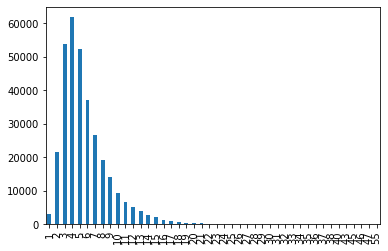

In [ ]:
q1_df_train[0].apply(lambda x: len(x.split(' '))).value_counts().sort_index().plot.bar()

In [ ]:
fname = data_dir + "fastText.vec/crawl-300d-2M.vec"
fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())

# Initilize random embeddings
embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
embeddings[word2idx['<pad>']] = np.zeros((d,))

# Load pretrained vectors
count = 0
for line in tqdm_notebook(fin):
    tokens = line.rstrip().split(' ')
    word = tokens[0]
    if word in word2idx:
        count += 1
        embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



There are 58952 / 78053 pretrained vectors found.


In [ ]:
embeddings = torch.tensor(embeddings)

In [ ]:
def encode(texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for sent in texts:
        tokenized_sent = sent.split()[:max_len]
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [ ]:
q1_train_inp_ids = encode(q1_df_train[0].to_list(), word2idx, 14)
q2_train_inp_ids = encode(q2_df_train[0].to_list(), word2idx, 14)
q1_test_inp_ids = encode(q1_df_test[0].to_list(), word2idx, 14)
q2_test_inp_ids = encode(q2_df_test[0].to_list(), word2idx, 14)

In [ ]:
train_inp_ids = np.stack([q1_train_inp_ids, q2_train_inp_ids], axis=-1)
test_inp_ids = np.stack([q1_test_inp_ids, q2_test_inp_ids], axis=-1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(train_inp_ids, Y_train, test_size=0.2)
X_test = test_inp_ids
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_val_t = torch.from_numpy(X_val)
Y_train_t = torch.from_numpy(Y_train.values.astype("float32"))
Y_test_t = torch.from_numpy(Y_test.values.astype("float32"))
Y_val_t = torch.from_numpy(Y_val.values.astype("float32"))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
iteration_list_val = []
iteration_list_train = []
loss_train_epoch = []

In [ ]:
batch_size = 100
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X #torch.tensor(X, dtype=torch.float32) #X
        self.Y = torch.tensor(Y, dtype=torch.float32) # Y.detach().clone() #torch.from_numpy(np.asarray(Y).astype('long'))

    def __getitem__(self, index):
        label = self.Y[index]
        image = self.X[index]
        return image, label

    def __len__(self):
        return len(self.X)

train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
class MyCNN(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self, pretrained_embedding=None, embed_dim=300, filter_sizes=[2, 3, 4, 5], num_filters=[100, 100, 100, 100], num_classes=1, dropout=0.3):
        super(MyCNN, self).__init__()
        self.vocab_size, self.embed_dim = pretrained_embedding.shape
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim*2, out_channels=num_filters[i], kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        # self.fc1 = nn.Linear(np.sum(num_filters), 256)
        # self.fc2 = nn.Linear(256, 128)
        # self.fc3 = nn.Linear(128, 32)
        # self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).view(-1, 14, 600).float() # reshape(-1, 15, 600).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

model = MyCNN(pretrained_embedding=embeddings)

model.to(device)
num_epochs = 1000
count = 0

error = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

# After running several times, this was found to be the best
learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
# learning_rate = 0.01
# # https://pytorch.org/docs/stable/optim.html
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%100 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 100, Val Loss: 420.313, Val Accuracy: 0.631 Train Loss: 1682.999, Train Accuracy: 0.630
Iteration: 200, Val Loss: 418.009, Val Accuracy: 0.631 Train Loss: 1673.973, Train Accuracy: 0.630
Iteration: 300, Val Loss: 416.323, Val Accuracy: 0.631 Train Loss: 1667.040, Train Accuracy: 0.630
Iteration: 400, Val Loss: 414.710, Val Accuracy: 0.631 Train Loss: 1660.727, Train Accuracy: 0.630
Iteration: 500, Val Loss: 413.052, Val Accuracy: 0.631 Train Loss: 1653.815, Train Accuracy: 0.630
Iteration: 600, Val Loss: 411.352, Val Accuracy: 0.631 Train Loss: 1647.049, Train Accuracy: 0.630
Iteration: 700, Val Loss: 409.680, Val Accuracy: 0.632 Train Loss: 1640.202, Train Accuracy: 0.630
Iteration: 800, Val Loss: 408.059, Val Accuracy: 0.632 Train Loss: 1633.699, Train Accuracy: 0.631
Iteration: 900, Val Loss: 406.546, Val Accuracy: 0.633 Train Loss: 1627.435, Train Accuracy: 0.631
Iteration: 1000, Val Loss: 404.829, Val Accuracy: 0.633 Train Loss: 1620.523, Train Accuracy: 0.632
Iteration

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.1
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%100 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 2400, Val Loss: 377.932, Val Accuracy: 0.701 Train Loss: 1508.921, Train Accuracy: 0.703
Iteration: 2500, Val Loss: 372.137, Val Accuracy: 0.703 Train Loss: 1484.234, Train Accuracy: 0.704
Iteration: 2600, Val Loss: 367.700, Val Accuracy: 0.709 Train Loss: 1464.847, Train Accuracy: 0.710
Iteration: 2700, Val Loss: 364.591, Val Accuracy: 0.717 Train Loss: 1451.376, Train Accuracy: 0.720
Iteration: 2800, Val Loss: 360.630, Val Accuracy: 0.720 Train Loss: 1434.105, Train Accuracy: 0.723
Iteration: 2900, Val Loss: 358.191, Val Accuracy: 0.721 Train Loss: 1422.572, Train Accuracy: 0.724
Iteration: 3000, Val Loss: 357.183, Val Accuracy: 0.725 Train Loss: 1418.050, Train Accuracy: 0.729
Iteration: 3100, Val Loss: 354.348, Val Accuracy: 0.724 Train Loss: 1405.693, Train Accuracy: 0.728
Iteration: 3200, Val Loss: 357.003, Val Accuracy: 0.726 Train Loss: 1415.544, Train Accuracy: 0.731
Iteration: 3300, Val Loss: 350.430, Val Accuracy: 0.727 Train Loss: 1386.184, Train Accuracy: 0.732


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.05
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%100 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 4500, Val Loss: 339.235, Val Accuracy: 0.740 Train Loss: 1328.721, Train Accuracy: 0.748
Iteration: 4600, Val Loss: 338.296, Val Accuracy: 0.738 Train Loss: 1323.685, Train Accuracy: 0.746
Iteration: 4700, Val Loss: 337.829, Val Accuracy: 0.740 Train Loss: 1320.652, Train Accuracy: 0.749
Iteration: 4800, Val Loss: 337.187, Val Accuracy: 0.742 Train Loss: 1318.138, Train Accuracy: 0.752
Iteration: 4900, Val Loss: 336.503, Val Accuracy: 0.742 Train Loss: 1314.274, Train Accuracy: 0.752
Iteration: 5000, Val Loss: 336.444, Val Accuracy: 0.742 Train Loss: 1313.123, Train Accuracy: 0.750
Iteration: 5100, Val Loss: 336.820, Val Accuracy: 0.743 Train Loss: 1315.024, Train Accuracy: 0.753
Iteration: 5200, Val Loss: 335.469, Val Accuracy: 0.743 Train Loss: 1308.871, Train Accuracy: 0.752
Iteration: 5300, Val Loss: 337.103, Val Accuracy: 0.744 Train Loss: 1315.297, Train Accuracy: 0.755
Iteration: 5400, Val Loss: 334.724, Val Accuracy: 0.743 Train Loss: 1303.589, Train Accuracy: 0.753


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%100 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 16400, Val Loss: 317.228, Val Accuracy: 0.762 Train Loss: 1187.765, Train Accuracy: 0.785
Iteration: 16500, Val Loss: 317.187, Val Accuracy: 0.761 Train Loss: 1186.805, Train Accuracy: 0.782
Iteration: 16600, Val Loss: 316.737, Val Accuracy: 0.763 Train Loss: 1184.663, Train Accuracy: 0.785
Iteration: 16700, Val Loss: 316.591, Val Accuracy: 0.761 Train Loss: 1184.125, Train Accuracy: 0.785
Iteration: 16800, Val Loss: 316.283, Val Accuracy: 0.763 Train Loss: 1182.621, Train Accuracy: 0.787
Iteration: 16900, Val Loss: 316.361, Val Accuracy: 0.762 Train Loss: 1182.467, Train Accuracy: 0.785
Iteration: 17000, Val Loss: 316.491, Val Accuracy: 0.762 Train Loss: 1183.298, Train Accuracy: 0.788
Iteration: 17100, Val Loss: 315.933, Val Accuracy: 0.763 Train Loss: 1180.707, Train Accuracy: 0.786
Iteration: 17200, Val Loss: 315.826, Val Accuracy: 0.763 Train Loss: 1180.125, Train Accuracy: 0.787
Iteration: 17300, Val Loss: 316.092, Val Accuracy: 0.762 Train Loss: 1180.400, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.01
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 10500, Val Loss: 347.786, Val Accuracy: 0.730 Train Loss: 1383.547, Train Accuracy: 0.734
Iteration: 11000, Val Loss: 347.314, Val Accuracy: 0.732 Train Loss: 1381.439, Train Accuracy: 0.735
Iteration: 11500, Val Loss: 347.236, Val Accuracy: 0.733 Train Loss: 1381.081, Train Accuracy: 0.736
Iteration: 12000, Val Loss: 347.169, Val Accuracy: 0.734 Train Loss: 1380.869, Train Accuracy: 0.737
Iteration: 12500, Val Loss: 346.979, Val Accuracy: 0.734 Train Loss: 1380.051, Train Accuracy: 0.737
Iteration: 13000, Val Loss: 347.136, Val Accuracy: 0.731 Train Loss: 1380.198, Train Accuracy: 0.735
Iteration: 13500, Val Loss: 346.556, Val Accuracy: 0.734 Train Loss: 1378.314, Train Accuracy: 0.736
Iteration: 14000, Val Loss: 346.663, Val Accuracy: 0.733 Train Loss: 1378.242, Train Accuracy: 0.737
Iteration: 14500, Val Loss: 346.600, Val Accuracy: 0.733 Train Loss: 1377.871, Train Accuracy: 0.736
Iteration: 15000, Val Loss: 346.655, Val Accuracy: 0.733 Train Loss: 1378.222, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0005
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 61500, Val Loss: 343.217, Val Accuracy: 0.737 Train Loss: 1362.633, Train Accuracy: 0.742
Iteration: 62000, Val Loss: 343.210, Val Accuracy: 0.737 Train Loss: 1362.591, Train Accuracy: 0.741
Iteration: 62500, Val Loss: 343.198, Val Accuracy: 0.737 Train Loss: 1362.551, Train Accuracy: 0.742
Iteration: 63000, Val Loss: 343.215, Val Accuracy: 0.737 Train Loss: 1362.584, Train Accuracy: 0.741
Iteration: 63500, Val Loss: 343.223, Val Accuracy: 0.738 Train Loss: 1362.651, Train Accuracy: 0.742
Iteration: 64000, Val Loss: 343.205, Val Accuracy: 0.737 Train Loss: 1362.564, Train Accuracy: 0.742
Iteration: 64500, Val Loss: 343.239, Val Accuracy: 0.737 Train Loss: 1362.680, Train Accuracy: 0.741
Iteration: 65000, Val Loss: 343.192, Val Accuracy: 0.738 Train Loss: 1362.539, Train Accuracy: 0.742
Iteration: 65500, Val Loss: 343.197, Val Accuracy: 0.737 Train Loss: 1362.542, Train Accuracy: 0.742
Iteration: 66000, Val Loss: 343.211, Val Accuracy: 0.737 Train Loss: 1362.555, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00001
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.95, weight_decay=0.005)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.005, momentum=0.5)
#train_dataset = MyDataset(X_train_t, Y_train_t)
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#test_dataset = MyDataset(X_test_t, Y_test_t)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#val_dataset = MyDataset(X_val_t, Y_val_t)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

Iteration: 114500, Val Loss: 343.172, Val Accuracy: 0.738 Train Loss: 1362.370, Train Accuracy: 0.742
Iteration: 115000, Val Loss: 343.171, Val Accuracy: 0.738 Train Loss: 1362.368, Train Accuracy: 0.742
Iteration: 115500, Val Loss: 343.171, Val Accuracy: 0.738 Train Loss: 1362.368, Train Accuracy: 0.742
Iteration: 116000, Val Loss: 343.171, Val Accuracy: 0.738 Train Loss: 1362.368, Train Accuracy: 0.742
Iteration: 116500, Val Loss: 343.171, Val Accuracy: 0.738 Train Loss: 1362.367, Train Accuracy: 0.742
Iteration: 117000, Val Loss: 343.171, Val Accuracy: 0.738 Train Loss: 1362.367, Train Accuracy: 0.742


In [ ]:
for param in list(model.children())[0].parameters():
    param.requires_grad = True

In [ ]:
with open(data_dir + "Models/fasttext_cnn.sav", "wb") as f:
    pickle.dump(model, f)

In [ ]:
with open(data_dir + "Models/fasttext_cnn.sav", "rb") as f:
    model = pickle.load(f)

EOFError: ignored

Text(0.5, 1.0, 'Training set Loss-Epoch')

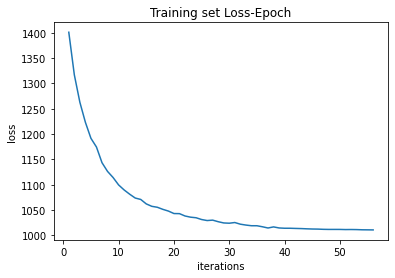

In [ ]:
loss_train_epoch_m = [i.item() for i in loss_train_epoch]
plt.plot([i+1 for i in range(len(iteration_list_train))], loss_train_epoch_m)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Training set Loss-Epoch")

Text(0.5, 1.0, 'Validation set Loss-iteration')

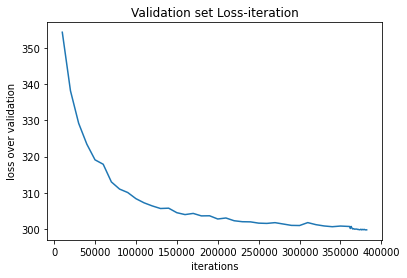

In [ ]:
loss_list_val_m = [i.item() for i in loss_list_val]
plt.plot(iteration_list_val, loss_list_val_m)
plt.xlabel("iterations")
plt.ylabel("loss over validation")
plt.title("Validation set Loss-iteration")

Text(0.5, 1.0, 'Validation set Accuracy-iteration')

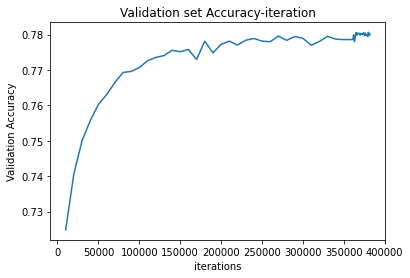

In [ ]:
accuracy_list_val_m = [i for i in accuracy_list_val]
plt.plot(iteration_list_val, accuracy_list_val_m)
plt.xlabel("iterations")
plt.ylabel("Validation Accuracy")
plt.title("Validation set Accuracy-iteration")

Text(0.5, 1.0, 'Training set Accuracy-iteration')

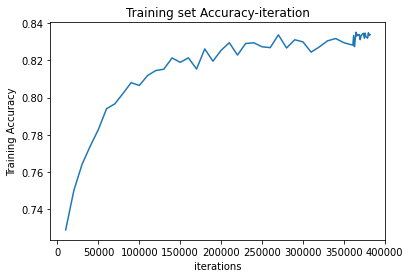

In [ ]:
accuracy_list_train_m = [i for i in accuracy_list_train]
plt.plot(iteration_list_train, accuracy_list_train_m)
plt.xlabel("iterations")
plt.ylabel("Training Accuracy")
plt.title("Training set Accuracy-iteration")

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Test Accuracy: {}, Test Loss: {}".format(accuracy, loss))
print("Test Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Test AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

RuntimeError: ignored

Val Accuracy: 0.7947037271785675, Val Loss: 285.34405517578125
Val Confusion Matrix
Val AUC:  0.8633649994920023


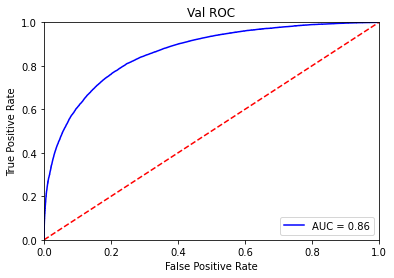

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84     40881
         1.0       0.76      0.65      0.70     23806

    accuracy                           0.79     64687
   macro avg       0.78      0.76      0.77     64687
weighted avg       0.79      0.79      0.79     64687



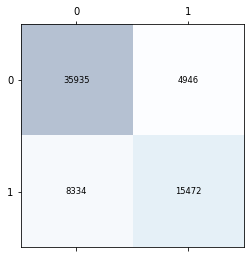

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Val Accuracy: {}, Val Loss: {}".format(accuracy, loss))
print("Val Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Val AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Val ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

In [ ]:
torch.cuda.empty_cache()
import gc
#del model
#del train_dataloader, test_dataloader, val_dataloader
gc.collect()

88

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(train_dataset, batch_size=100):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Train Accuracy: {}, Train Loss: {}".format(accuracy, loss))
print("Train Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Train AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

RuntimeError: ignored

In [ ]:
interm_model = nn.Sequential(*list(model.children())[:-1])
total = 0
correct = 0
loss = 0
out = []
labels_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = interm_model(test)
    labels_l.append(labels)
    out.append(outputs)

class pca:
    def __init__(self, n_components):
        """
        :param n_components: Number of principal components the data should be reduced too.
        """
        self.components = n_components

    def fit_transform(self, X):
        """
        * Centering our inputs with mean
        * Finding covariance matrix using centered tensor
        * Finding eigen value and eigen vector using torch.eig()
        * Sorting eigen values in descending order and finding index of high eigen values
        * Using sorted index, get the eigen vectors
        * Tranforming the Input vectors with n columns into PCA components with reduced dimension
        :param X: Input tensor with n columns.
        :return: Output tensor with reduced principal components
        """
        centering_X = X - torch.mean(X, dim=0)
        covariance_matrix = torch.mm(centering_X.T, centering_X)/(centering_X.shape[0] - 1)
        eigen_values, eigen_vectors = torch.eig(covariance_matrix, eigenvectors=True)
        eigen_sorted_index = torch.argsort(eigen_values[:,0],descending=True)
        eigen_vectors_sorted = eigen_vectors[:,eigen_sorted_index]
        component_vector = eigen_vectors_sorted[:,0:self.components]
        transformed = torch.mm(component_vector.T, centering_X.T).T
        return transformed
pca_out = pca(n_components=2).fit_transform(torch.cat(out))
pca_vector = pca_out
plt.figure(figsize=(12, 12))
sb.scatterplot(
    pca_vector[:, 0].detach().cpu(), 
    pca_vector[:, 1].detach().cpu(), 
    hue=torch.cat(labels_l).detach().cpu(), 
    #s=100, 
    palette="tab10"
)
plt.show()

TypeError: ignored